In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

In [2]:
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

# 1. Normoglycemic Population Model

In [3]:
Model_Normoglycemic = @stock_and_flow begin
    
    :stocks
    NormalWeight
    OverWeight
    Obese

    :parameters
    rBirth
    rMortalityWeight
    rObese
    rOverWeight
    rMortalityobese

    :flows
    NormalWeight => f_DeathNormalWeight(NormalWeight * rMortalityWeight) => CLOUD
    NormalWeight => f_BecomingOverWeight(NormalWeight * rOverWeight) => OverWeight
    OverWeight => f_DeathOverWeight(OverWeight * rMortalityWeight) => CLOUD
    OverWeight => f_BecomingObese(OverWeight * rObese) => Obese
    Obese => f_DeathObese(Obese * rMortalityobese) => CLOUD
    CLOUD => f_NewBorn(N * rBirth) => NormalWeight


    :sums
    N = [NormalWeight, OverWeight, Obese]

end

StockAndFlowF with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:6, I = 1:3, O = 1:5, V = 1:6, LV = 1:5, LSV = 1:1, P = 1:5, LVV = 1:0, LPV = 1:6
┌───┬──────────────┐
│ S │        sname │
├───┼──────────────┤
│ 1 │ NormalWeight │
│ 2 │   OverWeight │
│ 3 │        Obese │
└───┴──────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────────────┐
│ F │ fv │                fname │
├───┼────┼──────────────────────┤
│ 1 │  1 │  f_DeathNormalWeight │
│ 2 │  2 │ f_BecomingOverWeight │
│ 3 │  3 │    f_DeathOverWeight │
│ 4 │  4 │      f_BecomingObese │
│ 5 │  5 │         f_DeathObese │
│ 6 │  6 │            f_NewBorn │
└───┴────┴──────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   6 │  1 │
│ 2 │   2 │  2 │
│ 3 │   4 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  2 │
│ 4 │   4 │  2 │
│ 5 │   5 │  3 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │  ##v_f_DeathNormalWeight#292 │   * │
│ 2 │ ##v_f_BecomingOverWeight#293 │   * │
│ 3 │    ##v_f_DeathOverWeight#294 │   * │
│ 4 │      ##v_f_BecomingObese#295 │   * │
│ 5 │         ##v_f_DeathObese#296 │   * │
│ 6 │            ##v_f_NewBorn#297 │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   1 │   2 │           1 │
│  3 │   2 │   3 │           1 │
│  4 │   2 │   4 │           1 │
│  5 │   3 │   5 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    6 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────────────┐
│ P │            pname │
├───┼──────────────────┤
│ 1 │           rBirth │
│ 2 │ rMortalityWeight │
│ 3 │           rObese │
│ 4 │      rOverWeight │
│ 5 │  rMortalityobese │
└───┴──────────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    2 │    1 │            2 │
│   2 │    4 │    2 │            2 │
│   3 │    2 │    3 │            2 │
│   4 │    3 │    4 │            2 │
│   5 │    5 │    5 │            2 │
│   6 │    1 │    6 │            2 │
└─────┴──────┴──────┴──────────────┘

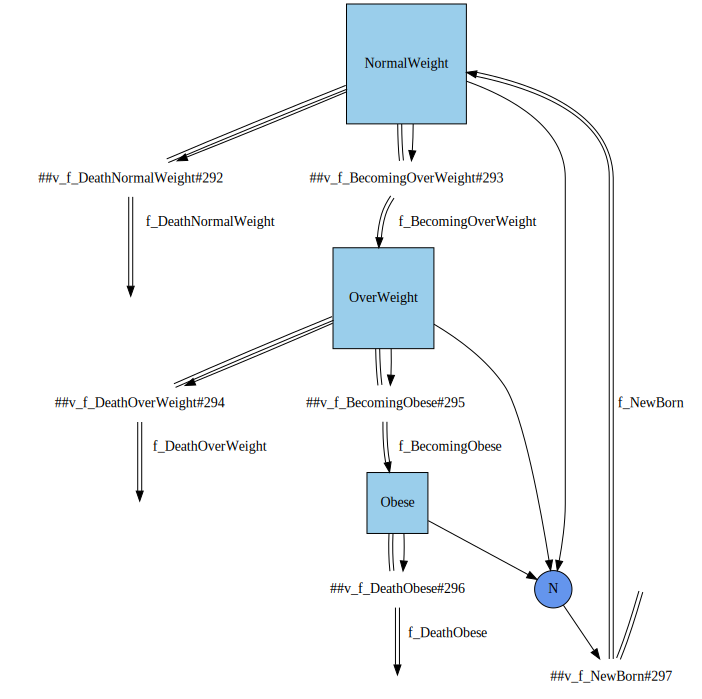

In [4]:
Graph(Model_Normoglycemic, rd="TB")

# 2. Hyperglycemic Population Model
## 2.1 Build Development of Hyperglyce Sub Model Structure

In [5]:
++(s1, s2) = Symbol(string(s1) * string(s2)) # infix, and works with both strings and symbols

function fOpenSubHyperglycemic(pop)
    
    # The following are all symbols
    
    Prediabetic = "Prediabetic" ++ pop
    DevelopingDiabetic = "DevelopingDiabetic" ++ pop
    DeathPrediabetic = "DeathPrediabetic" ++ pop
    DiabeticWtComp = "DiabeticWtComp" ++ pop
    DiabeticEarly = "DiabeticEarly" ++ pop
    DevelopingEarly = "DevelopingEarly" ++ pop
    DeathDiabeticWtComp = "DeathDiabeticWtComp" ++ pop
    DevelopingLate = "DevelopingLate" ++ pop
    DeathDiabeticEarly = "DeathDiabeticEarly" ++ pop
    DiabeticLate = "DiabeticLate" ++ pop
    DeathDiabeticLate = "DeathDiabeticLate" ++ pop

    rDevelopingDiabetic = "rDevelopingDiabetic" ++ pop
    rDevelopingEarly = "rDevelopingEarly" ++ pop
    rMortalityDiabeticEarly = "rMortalityDiabeticEarly" ++ pop
    rMortalityDiabeticWtComp = "rMortalityDiabeticWtComp" ++ pop

    v_DevelopingDiabetic = "v_DevelopingDiabetic" ++ pop
    v_DeathPrediabetic = "v_DeathPrediabetic" ++ pop
    v_DevelopingEarly = "v_DevelopingEarly" ++ pop
    v_DeathDiabeticWtComp = "v_DeathDiabeticWtComp" ++ pop
    v_DevelopingLate = "v_DevelopingLate" ++ pop
    v_DeathDiabeticEarly = "v_DeathDiabeticEarly" ++ pop
    v_DeathDiabeticLate = "v_DeathDiabeticLate" ++ pop


    rMortalityPrediabetic = :rMortalityPrediabetic
    rMortalityDiabeticLate = :rMortalityDiabeticLate
    rDevelopingLate = :rDevelopingLate

        Open(
        StockAndFlowF(
            
            #stocks
            # in, out, sums
            (
                Prediabetic => (:F_NONE, (DevelopingDiabetic, DeathPrediabetic), :N),
                DiabeticWtComp => (DevelopingDiabetic, (DevelopingEarly, DeathDiabeticWtComp), :N),
                DiabeticEarly => (DevelopingEarly, (DevelopingLate, DeathDiabeticEarly), :N),
                DiabeticLate => (DevelopingLate, DeathDiabeticLate, :N)
            ),

            #parameters
            (
                rDevelopingDiabetic,
                rMortalityPrediabetic,
                rDevelopingEarly,
                rMortalityDiabeticEarly,
                rMortalityDiabeticLate,
                rMortalityDiabeticWtComp,
                rDevelopingLate
            ),

            #dynamic variables
            (
                v_DevelopingDiabetic => ((Prediabetic, rDevelopingDiabetic) => :*),
                v_DeathPrediabetic => ((Prediabetic, rMortalityPrediabetic) => :*),
                v_DevelopingEarly => ((DiabeticWtComp, rDevelopingEarly) => :*),
                v_DeathDiabeticWtComp => ((DiabeticWtComp, rMortalityDiabeticWtComp) => :*),
                v_DevelopingLate => ((DiabeticEarly, rDevelopingLate) => :*),
                v_DeathDiabeticEarly => ((DiabeticEarly, rMortalityDiabeticEarly) => :*),
                v_DeathDiabeticLate => ((DiabeticLate, rMortalityDiabeticLate) => :*),
            ),

            #flows
            (
                DevelopingDiabetic => v_DevelopingDiabetic,
                DeathPrediabetic => v_DeathPrediabetic,
                DevelopingEarly => v_DevelopingEarly,
                DeathDiabeticWtComp => v_DeathDiabeticWtComp,
                DevelopingLate => v_DevelopingLate,
                DeathDiabeticEarly => v_DeathDiabeticEarly,
                DeathDiabeticLate => v_DeathDiabeticLate
            ),

            #sums
            (
                :N
            )

        ),

        # feet
        foot(Prediabetic, :N, Prediabetic=>:N),
        foot(DiabeticWtComp, :N, DiabeticWtComp=>:N),
        foot(DiabeticEarly, :N, DiabeticEarly=>:N),
        foot(DiabeticLate, :N, DiabeticLate=>:N)
        
    )
end

fOpenSubHyperglycemic (generic function with 1 method)

## 2.2 Build Diagnosis of Hyperglyce Sub Model Structure

In [6]:
function fOpensubDiagnosis(s)

    # The following are all symbols
    
    s_U = s ++ "_U"
    s_D = s ++ "_D"

    Diagnosis = "Diagnosis" ++ s
    v_Diagnosis = "v_Diagnosis" ++ s
    
    rs = "r" ++ s

    Open(
        StockAndFlowF(

            #stocks
            (
                s_U => (:F_NONE, Diagnosis, :N),
                s_D => (Diagnosis, :F_NONE, :N)
            ),
            
            #parameters
            (
                rs
            ),
            
            #dynamic variables
            (
                v_Diagnosis => ((s_U, rs) => :*)
            ),
            
            #flows
            (
                Diagnosis => v_Diagnosis
            ),
            
            #sums
            (
                :N
            )

        ),
        
        # feet
        foot(s_U, :N, s_U => :N),
        foot(s_D, :N, s_D => :N)

    )

end

fOpensubDiagnosis (generic function with 1 method)

## 2.3 Generate Hyperglycemic Model by Composition

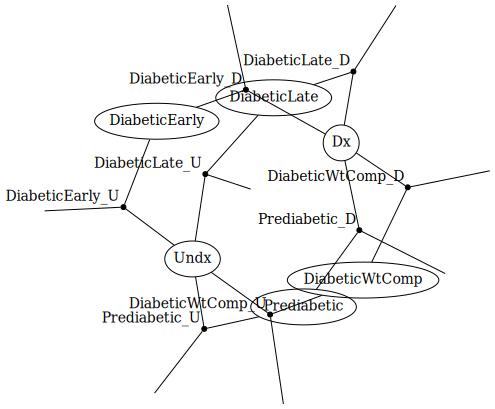

In [7]:
# define the UWD-algebra of Hyperglycemic Model
hyperglycemic_uwd = @relation (Prediabetic_U,Prediabetic_D,DiabeticWtComp_U,DiabeticWtComp_D,DiabeticEarly_U,DiabeticEarly_D,DiabeticLate_U,DiabeticLate_D) begin
    Undx(Prediabetic_U,DiabeticWtComp_U,DiabeticEarly_U,DiabeticLate_U)
    Dx(Prediabetic_D,DiabeticWtComp_D,DiabeticEarly_D,DiabeticLate_D)
    Prediabetic(Prediabetic_U,Prediabetic_D)
    DiabeticWtComp(DiabeticWtComp_U,DiabeticWtComp_D)
    DiabeticEarly(DiabeticEarly_U,DiabeticEarly_D)
    DiabeticLate(DiabeticLate_U,DiabeticLate_D)
end;
display_uwd(hyperglycemic_uwd)

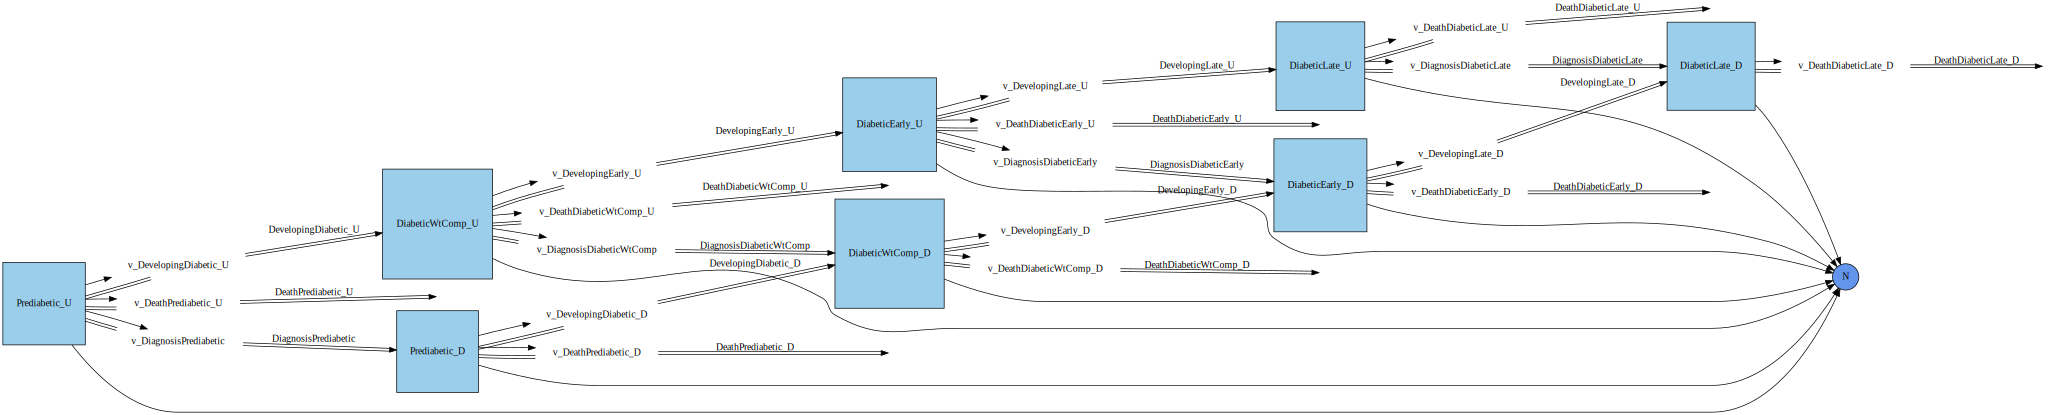

In [8]:
# generate the Hyperglycemic population model by composition
Model_Hyperglycemic=oapply(hyperglycemic_uwd, 
    [fOpenSubHyperglycemic("_U"),fOpenSubHyperglycemic("_D"),fOpensubDiagnosis("Prediabetic"),fOpensubDiagnosis("DiabeticWtComp"),fOpensubDiagnosis("DiabeticEarly"),fOpensubDiagnosis("DiabeticLate")]) |> apex
Graph(Model_Hyperglycemic)

# 3. Connection between Normoglycemic and Hyperglycemic Population Model

In [9]:
Model_Norm_Hyper = @stock_and_flow begin
    
    :stocks
    NormalWeight
    OverWeight
    Obese
    Prediabetic_U
    Prediabetic_D

    :parameters
    rRecovery
    rIncidenceNW
    rIncidenceOW
    rIncidenceOB

    :flows
    Prediabetic_D => fRecoveryToOWFromDx(Prediabetic_D * rRecovery) => OverWeight
    Prediabetic_D => fRecoveryToNWFromDx(Prediabetic_D * rRecovery) => NormalWeight
    Prediabetic_D => fRecoveryToOBFromDx(Prediabetic_D * rRecovery) => Obese

    NormalWeight => fDevelopingPrediabeticNW(NormalWeight * rIncidenceNW) => Prediabetic_U

    Prediabetic_U => fRecoveryToOWFromUx(Prediabetic_U * rRecovery) => OverWeight
    Prediabetic_U => fRecoveryToOBFromUx(Prediabetic_U * rRecovery) => Obese
    Prediabetic_U => fRecoveryToNWFromUx(Prediabetic_U * rRecovery) => NormalWeight

    OverWeight => fDevelopingPrediabeticOW(OverWeight * rIncidenceOW) => Prediabetic_U

    Obese => fDevelopingPrediabeticOB(Obese * rIncidenceOB) => Prediabetic_U

    :sums
    N = [NormalWeight, OverWeight, Obese, Prediabetic_U, Prediabetic_D]


end

StockAndFlowF with elements S = 1:5, SV = 1:1, LS = 1:5, F = 1:9, I = 1:9, O = 1:9, V = 1:9, LV = 1:9, LSV = 1:0, P = 1:4, LVV = 1:0, LPV = 1:9
┌───┬───────────────┐
│ S │         sname │
├───┼───────────────┤
│ 1 │  NormalWeight │
│ 2 │    OverWeight │
│ 3 │         Obese │
│ 4 │ Prediabetic_U │
│ 5 │ Prediabetic_D │
└───┴───────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    1 │
│  5 │   5 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────────────────┐
│ F │ fv │                    fname │
├───┼────┼──────────────────────────┤
│ 1 │  1 │      fRecoveryToOWFromDx │
│ 2 │  2 │      fRecoveryToNWFromDx │
│ 3 │  3 │      fRecoveryToOBFromDx │
│ 4 │  4 │ fDevelopingPrediabeticNW │
│ 5 │  5 │      fRecoveryToOWFromUx │
│ 6 │  6 │      fRecoveryToOBFromUx │
│ 7 │  7 │      fRecoveryToNWFromUx │
│ 8 │  8 │ fDevelopingPrediabeticOW │
│ 9 │  9 │ fDevelopingPrediabeticOB │
└───┴────┴──────────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   7 │  1 │
│ 3 │   1 │  2 │
│ 4 │   5 │  2 │
│ 5 │   3 │  3 │
│ 6 │   6 │  3 │
│ 7 │   4 │  4 │
│ 8 │   8 │  4 │
│ 9 │   9 │  4 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   4 │  1 │
│ 2 │   8 │  2 │
│ 3 │   9 │  3 │
│ 4 │   5 │  4 │
│ 5 │   6 │  4 │
│ 6 │   7 │  4 │
│ 7 │   1 │  5 │
│ 8 │   2 │  5 │
│ 9 │   3 │  5 │
└───┴─────┴────┘
┌───┬──────────────────────────────────┬─────┐
│ V │                            vname │ vop │
├───┼──────────────────────────────────┼─────┤
│ 1 │      ##v_fRecoveryToOWFromDx#298 │   * │
│ 2 │      ##v_fRecoveryToNWFromDx#299 │   * │
│ 3 │      ##v_fRecoveryToOBFromDx#300 │   * │
│ 4 │ ##v_fDevelopingPrediabeticNW#301 │   * │
│ 5 │      ##v_fRecoveryToOWFromUx#302 │   * │
│ 6 │      ##v_fRecoveryToOBFromUx#303 │   * │
│ 7 │      ##v_fRecoveryToNWFromUx#304 │   * │
│ 8 │ ##v_fDevelopingPrediabeticOW#305 │   * │
│ 9 │ ##v_fDevelopingPrediabeticOB#306 │   * │
└───┴──────────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   5 │   1 │           1 │
│  2 │   5 │   2 │           1 │
│  3 │   5 │   3 │           1 │
│  4 │   1 │   4 │           1 │
│  5 │   4 │   5 │           1 │
│  6 │   4 │   6 │           1 │
│  7 │   4 │   7 │           1 │
│  8 │   2 │   8 │           1 │
│  9 │   3 │   9 │           1 │
└────┴─────┴─────┴─────────────┘
┌───┬──────────────┐
│ P │        pname │
├───┼──────────────┤
│ 1 │    rRecovery │
│ 2 │ rIncidenceNW │
│ 3 │ rIncidenceOW │
│ 4 │ rIncidenceOB │
└───┴──────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    1 │    2 │            2 │
│   3 │    1 │    3 │            2 │
│   4 │    2 │    4 │            2 │
│   5 │    1 │    5 │            2 │
│   6 │    1 │    6 │            2 │
│   7 │    1 │    7 │            2 │
│   8 │    3 │    8 │            2 │
│   9 │    4 │    9 │            2 │
└─────┴──────┴──────┴──────────────┘

# 4 Generate Final Diabetes Model by Composition

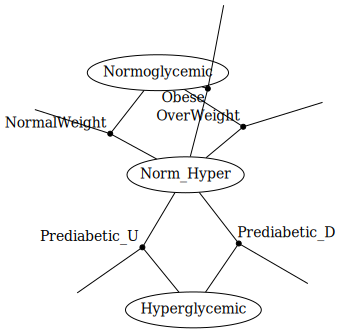

In [10]:
# define the UWD-algebra of Hyperglycemic Model
diabetes_uwd = @relation (NormalWeight,OverWeight,Obese,Prediabetic_U,Prediabetic_D) begin
    Normoglycemic(NormalWeight,OverWeight,Obese)
    Hyperglycemic(Prediabetic_U,Prediabetic_D)
    Norm_Hyper(NormalWeight,OverWeight,Obese,Prediabetic_U,Prediabetic_D)
end;
display_uwd(diabetes_uwd)

In [11]:
Diabetes_Model = oapply(diabetes_uwd,Dict(
    :Normoglycemic=>Open(Model_Normoglycemic,foot(:NormalWeight,:N,:NormalWeight=>:N),foot(:OverWeight,:N,:OverWeight=>:N),foot(:Obese,:N,:Obese=>:N)),
    :Hyperglycemic=>Open(Model_Hyperglycemic,foot(:Prediabetic_U,:N,:Prediabetic_U=>:N),foot(:Prediabetic_D,:N,:Prediabetic_D=>:N)),
    :Norm_Hyper=>Open(Model_Norm_Hyper,foot(:NormalWeight,:N,:NormalWeight=>:N),foot(:OverWeight,:N,:OverWeight=>:N),foot(:Obese,:N,:Obese=>:N),foot(:Prediabetic_U,:N,:Prediabetic_U=>:N),foot(:Prediabetic_D,:N,:Prediabetic_D=>:N))    
    )) |> apex

S,sname
1,NormalWeight
2,OverWeight
3,Obese
4,Prediabetic_U
5,DiabeticWtComp_U
6,DiabeticEarly_U
7,DiabeticLate_U
8,Prediabetic_D
9,DiabeticWtComp_D
10,DiabeticEarly_D


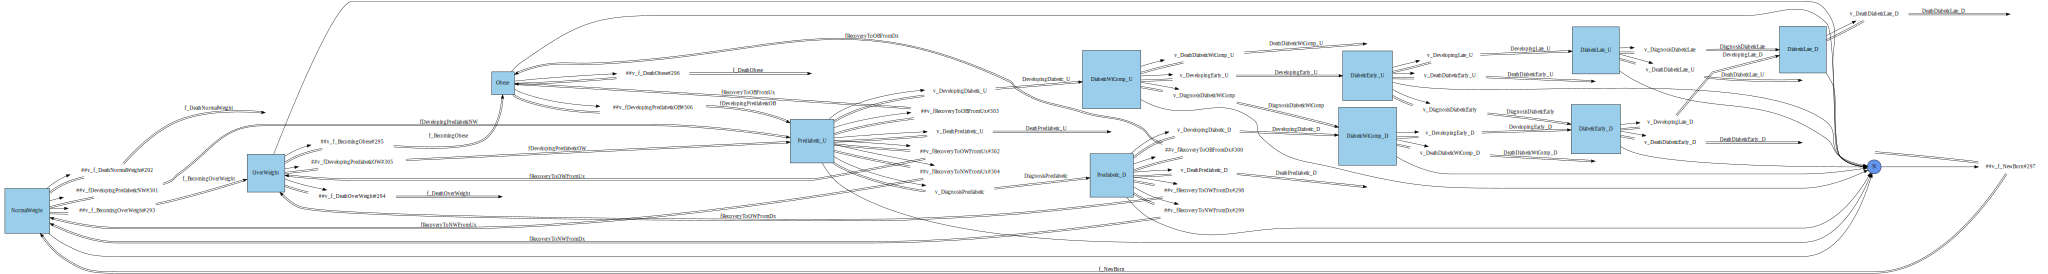

In [12]:
Graph(Diabetes_Model)

In [13]:
p = LVector(
    rBirth=12.5/1000, rMortalityWeight=4.0/1000, rOverWeight=0.03, rObese=0.06, rMortalityobese=13.0/1000,
    rDevelopingDiabetic_U=1.0/10.0, rDevelopingDiabetic_D=1.0/15.0, rMortalityPrediabetic=13.0/1000,
    rDevelopingEarly_U=1.0/10.0, rDevelopingEarly_D=1.0/15.0, rMortalityDiabeticWtComp_U=0.03, rMortalityDiabeticWtComp_D=0.027,
    rDevelopingLate=0.9, rMortalityDiabeticEarly_U=0.04+0.02, rMortalityDiabeticEarly_D=0.036+0.02,rMortalityDiabeticLate=0.04,
    rPrediabetic=0.1, rDiabeticWtComp=0.24, rDiabeticEarly=0.4, rDiabeticLate=0.6, rRecovery=0.03,
    rIncidenceNW=0.01, rIncidenceOW=0.017, rIncidenceOB=0.026
)
u0 = LVector(
    NormalWeight=95811.0, OverWeight=27709.0, Obese=30770.0, Prediabetic_U=13615.0, Prediabetic_D=2000.0,
    DiabeticWtComp_U=6396.0, DiabeticWtComp_D=3000.0, DiabeticEarly_U=0.0, DiabeticEarly_D=1200.0,
    DiabeticLate_U=0.0, DiabeticLate_D=800.0 
)

11-element LArray{Float64, 1, Vector{Float64}, (:NormalWeight, :OverWeight, :Obese, :Prediabetic_U, :Prediabetic_D, :DiabeticWtComp_U, :DiabeticWtComp_D, :DiabeticEarly_U, :DiabeticEarly_D, :DiabeticLate_U, :DiabeticLate_D)}:
     :NormalWeight => 95811.0
       :OverWeight => 27709.0
            :Obese => 30770.0
    :Prediabetic_U => 13615.0
    :Prediabetic_D => 2000.0
 :DiabeticWtComp_U => 6396.0
 :DiabeticWtComp_D => 3000.0
  :DiabeticEarly_U => 0.0
  :DiabeticEarly_D => 1200.0
   :DiabeticLate_U => 0.0
   :DiabeticLate_D => 800.0

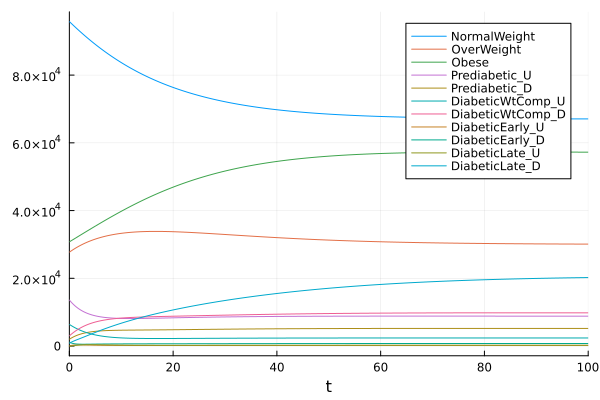

In [14]:
# results have been tested correct (same as the Anylogic model)
prob_diabetes = ODEProblem(vectorfield(Diabetes_Model),u0,(0.0,100.0),p);
sol_diabetes = solve(prob_diabetes,Tsit5(),abstol=1e-8);
plot(sol_diabetes)